**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [47]:
import warnings

warnings.filterwarnings('ignore')

In [48]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time

In [49]:
start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

2.590183973312378


In [50]:
#调用模块
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

In [51]:
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [52]:
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

In [53]:
Gap30 = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

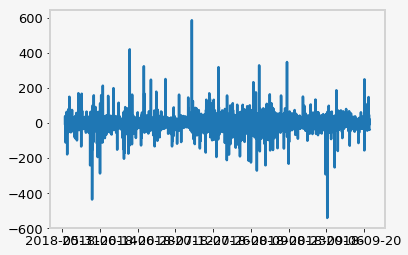

In [54]:
#观察30min价差
import matplotlib.pyplot as plt


plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

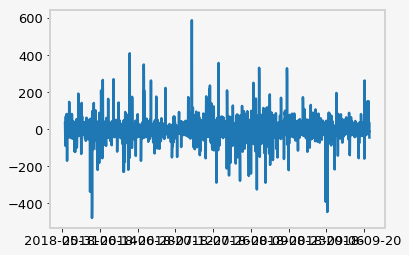

In [55]:
#观察1H价差
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [56]:
# 进场信号
long = dv1H.add_formula("long","If((Ts_Mean(close,20)>Ts_Mean(close,55)) && (Delay(Ts_Mean(close,20),1)<=Delay(Ts_Mean(close,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("short","If((Ts_Mean(close,20)<Ts_Mean(close,55)) && (Delay(Ts_Mean(close,20),1)>=Delay(Ts_Mean(close,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

In [57]:
dv1H.get_ts('long').stack()[dv1H.get_ts('long').stack()==2]#观察出现做多信号的时间点

trade_date      symbol         
20180606120000  BTCUSDT:binance    2.0
20180615040000  BTCUSDT:binance    2.0
20180617170000  BTCUSDT:binance    2.0
20180619040000  BTCUSDT:binance    2.0
20180621090000  BTCUSDT:binance    2.0
20180625130000  BTCUSDT:binance    2.0
20180630120000  BTCUSDT:binance    2.0
20180702220000  BTCUSDT:binance    2.0
20180707120000  BTCUSDT:binance    2.0
20180714120000  BTCUSDT:binance    2.0
20180722120000  BTCUSDT:binance    2.0
20180728130000  BTCUSDT:binance    2.0
20180730120000  BTCUSDT:binance    2.0
20180808010000  BTCUSDT:binance    2.0
20180810110000  BTCUSDT:binance    2.0
20180812160000  BTCUSDT:binance    2.0
20180815190000  BTCUSDT:binance    2.0
20180820110000  BTCUSDT:binance    2.0
20180822080000  BTCUSDT:binance    2.0
20180824190000  BTCUSDT:binance    2.0
20180827180000  BTCUSDT:binance    2.0
20180901020000  BTCUSDT:binance    2.0
20180910100000  BTCUSDT:binance    2.0
20180913090000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance 

In [68]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True)

In [69]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [70]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha1_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

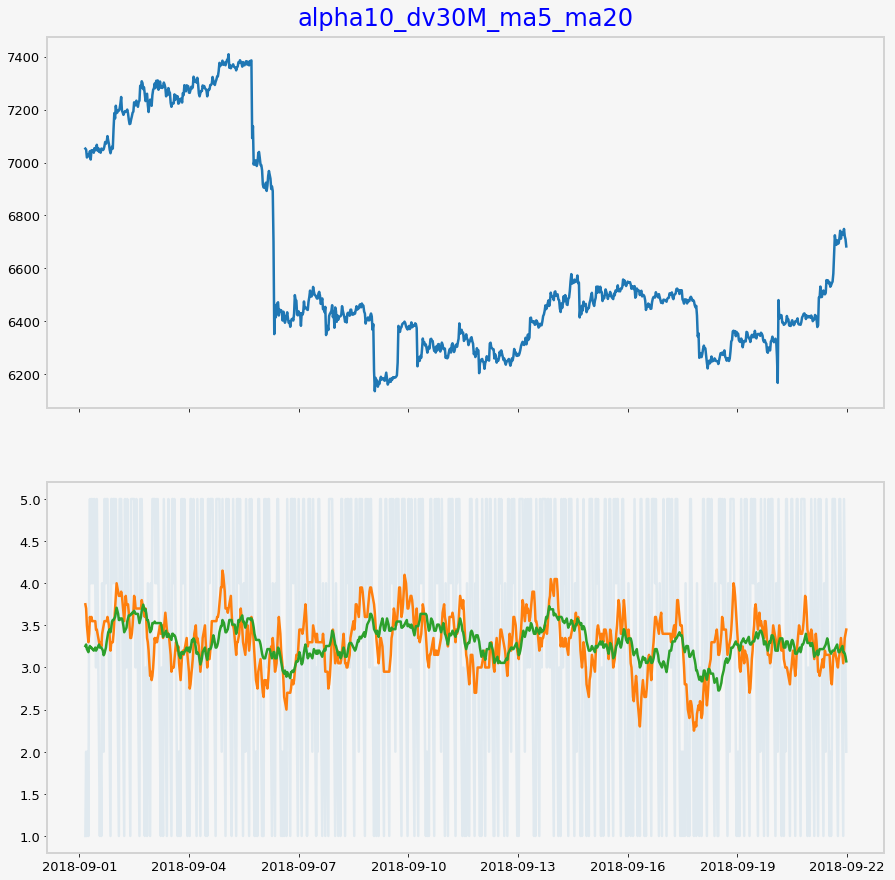

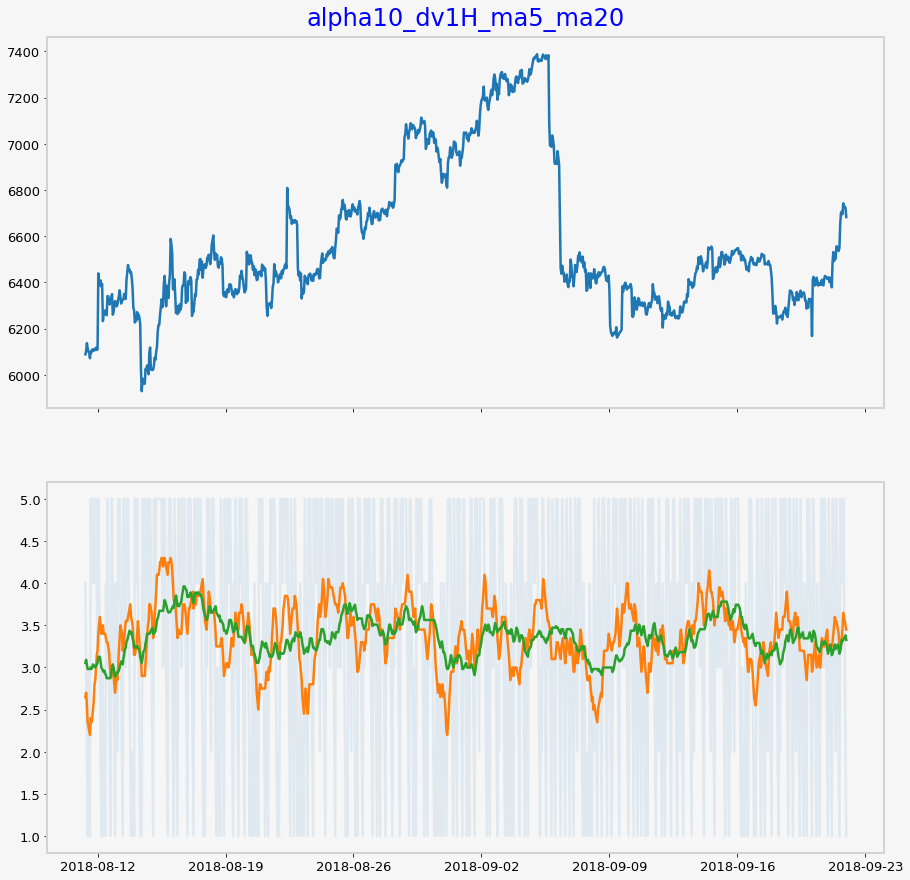

In [72]:
import pandas as pd
for name, alpha in alpha1_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=20, LongPeriod=55, n=-1000)#橘色短线 绿色长线

In [73]:
#同时计算多空头信号的绩效
tdMaStatistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.290  -9.733   0.570
p-value              0.000   0.000   0.570
mean                 0.049  -0.019   0.003
std                  0.047   0.014   0.043
info_ratio           1.058  -1.312   0.063
skewness             1.273  -1.214   1.910
kurtosis             1.195   0.872   4.465
pct5                 0.002  -0.049  -0.045
pct25                0.014  -0.024  -0.017
pct50                0.039  -0.014  -0.010
pct75                0.075  -0.009   0.005
pct95                0.148  -0.002   0.089
occurance           26.000  56.000  82.000
win_ratio              NaN     NaN   0.317
win_mean/loss_mean     NaN     NaN   2.607


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [26]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

2.4469680786132812


In [27]:
data1H = Time_dict.set_index('datetime')

In [28]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()

In [29]:
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [31]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [32]:
Big_Up = dv1H.add_formula('Big_Up','If((close/open>1.02) && (high/low<(close/open+0.02)), 100, 0)', add_data=True)

In [33]:
Big_Up[Big_Up['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
20180605230000,100.0
20180611160000,100.0
20180614100000,100.0
20180615000000,100.0
20180617000000,100.0
20180619000000,100.0
20180625000000,100.0
20180625220000,100.0
20180630060000,100.0


In [34]:
dataBigUp = dv1H.get_ts('Big_Up', date_type='datetime')

In [35]:
dataBigUp[dataBigUp['BTCUSDT:binance']==100].index

DatetimeIndex(['2018-06-05 23:00:00', '2018-06-11 16:00:00',
               '2018-06-14 10:00:00', '2018-06-15 00:00:00',
               '2018-06-17 00:00:00', '2018-06-19 00:00:00',
               '2018-06-25 00:00:00', '2018-06-25 22:00:00',
               '2018-06-30 06:00:00', '2018-06-30 09:00:00',
               '2018-07-02 21:00:00', '2018-07-04 21:00:00',
               '2018-07-08 07:00:00', '2018-07-16 17:00:00',
               '2018-07-18 01:00:00', '2018-07-18 02:00:00',
               '2018-07-27 23:00:00', '2018-08-10 20:00:00',
               '2018-08-12 01:00:00', '2018-08-16 00:00:00',
               '2018-08-20 04:00:00', '2018-08-22 09:00:00',
               '2018-08-28 07:00:00', '2018-09-09 17:00:00'],
              dtype='datetime64[ns]', name='trade_date', freq=None)

In [36]:
scatterBigUpX = dataBigUp[dataBigUp['BTCUSDT:binance']==100].index

In [37]:
scatterBigUpY = data1H.loc[scatterBigUpX].low-100

In [38]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

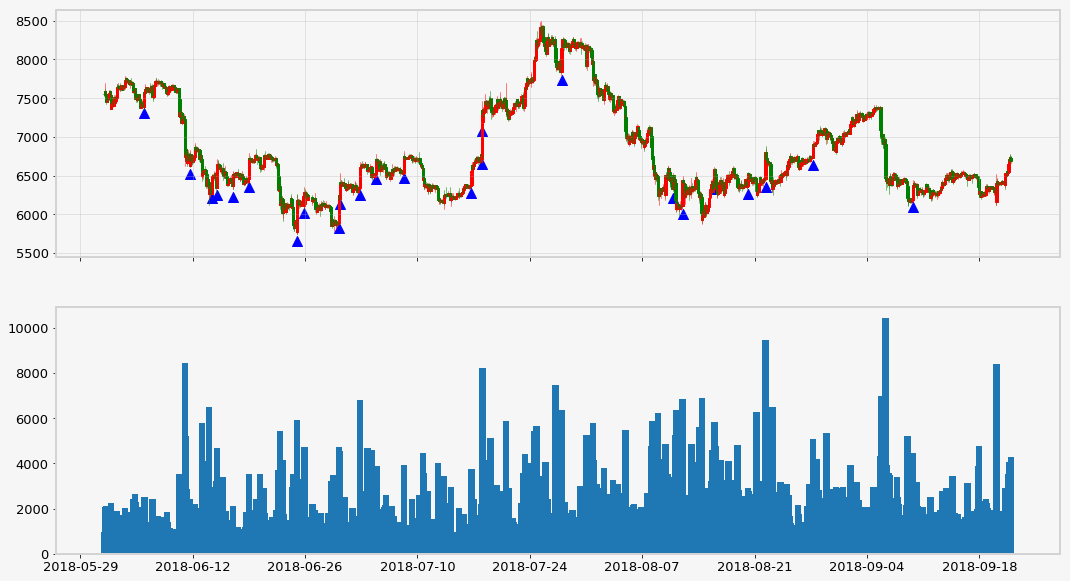

In [39]:
draw_candle(candle, scatterBigUpX, scatterBigUpY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来
